# The Welch's method

In [1]:
%pylab inline
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import pi as PI
from scipy import signal
from scipy.integrate import simps


## Computing the power spectrum


The spectral power computes the power of the signal versus the frequency. To compute the spectrum, the data can be taken into a number of component oscillations using the Fourier transform. The spectral amplitude distribution is the series of amplitudes for each component of the oscillation. To obtain the power spectrum of a signal, we square the amplitude of the oscillation to obtain the power. 

It is generaly advisable to define the **spectral resolution** or **frequency resolution**. 
It is the spacing between successive frequencies, and it is given by the ratio between the sampling rate and the total number of samples of the signal. 

<BR>
$$
\text{Spectral resolution} = \frac{\text{Sampling Rate}}{\text{Nsamples}}
$$
    
<BR>
The Welch method computes an estimate of the power spectrum by averaging the data into overlapping segments, 
The length of the segment determin the appropiate spectral resolution.
<BR>
    
Other aspects to take into account is the tappering window to be applied, and the degree of overlap between segments.
    



In [3]:
%ls data

2019-06-06CM_ch25.npy  EEGrestingState.mat  EEG.txt


## A synthetic sine wave 

A 30 seconds **sine** signal sampled at 100 Hz

Nysquid frequency is 50 Hz


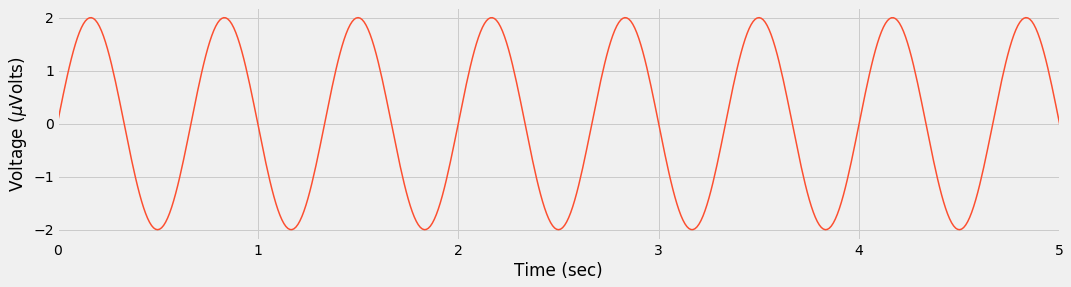

In [4]:
sr = 100
Nysquid = sr/2
print('Nysquid frequency is %d Hz'%Nysquid)
t = np.linspace(0,30,num=30*sr)
mysine = lambda f: np.sin(2*PI*f*t) 

sine = 2*mysine(1.5)
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(t, sine, lw = 1.5, color='C1')
plt.xlabel('Time (sec)'), plt.ylabel('Voltage ($\mu$Volts)');
plt.xlim(0,5);


The two normalizations necessary to obtain the amplitudes from the Fourier coefficients are:

    1) Divide the Fourier coefficients by the size of the signal
    2) multipy by two to obtain the amplitude of the negative frequencies
    
In addition, we can set the DC-component to zero.

In [5]:
# Fourier transform
FourierCoeff = np.fft.fft(sine)/sine.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(sine.size/2) )
hz = np.linspace(0, sr/2., num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%dhz)

Spectral resolution = 0.0333 Hz


For the Welch's periodogram, the spectral resolution is given by the lenght of the segment. If we take a segment that correspond to the sampling rate, then the frequency resolution is 1 Hz. A larger segment (e.g., 4 times the size of the sampling rate) would give a higher frequency resolution (0.25 Hz). 

Welch's periodogram will return the power (amplitude to the square) versus frequency. We can also have the power density. Power density is the power per Hz, and if we take a segment which is four times the sampling rate, then the power will be multiplied by four to return power/Hz. In this case, when we add in Welch's, **scaling=density** and will obtain the power times 4, because our segment has a lenght of four times the sampling rate.

In [6]:
# Perform Welch's periodogram
segment = int( sr*4 ) 
myhann = signal.get_window('hann', segment)

# obtain simply Power (amplitude^2) withouth tappering
myparams = dict(fs = sr, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'spectrum', return_onesided=True)
freq, ps = signal.welch(x = sine, **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

#obtain Power density (amplitude^2/Hz) withouth tappering
myparams = dict(fs = sr, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = sine, **myparams)# units uV**2/Hz
psd = 2*psd # correct for negative frequencies

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


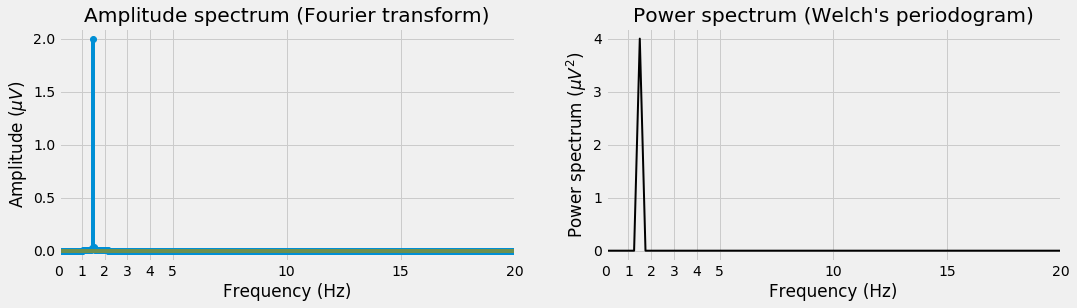

In [7]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(freq, ps, color='k', lw=2) 
ax[1].set_ylabel('Power spectrum ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,20)
    myticks = list(range(6)) + list(range(10, 25,5))
    myax.set_xticks(myticks)

In [8]:
# Sine wave has an amplitude of 2 uV, the power is 4 uV and the power density is 4*4 because
# we took a segment with size = 4x the sampling rate
print('Signal amplitude     = %2.4f uVolts'%amp[int(1.5/dhz)]) 
print('Signal power         = %2.4f uVolts^2'%ps[int(1.5/dfreq)])
print('Singal power density = %2.4f uVolts^2/Hz'%psd[int(1.5/dfreq)])

Signal amplitude     = 1.9989 uVolts
Signal power         = 3.9986 uVolts^2
Singal power density = 15.9945 uVolts^2/Hz


## Example of EGG with delta band

Nysquid frequency is 50 Hz


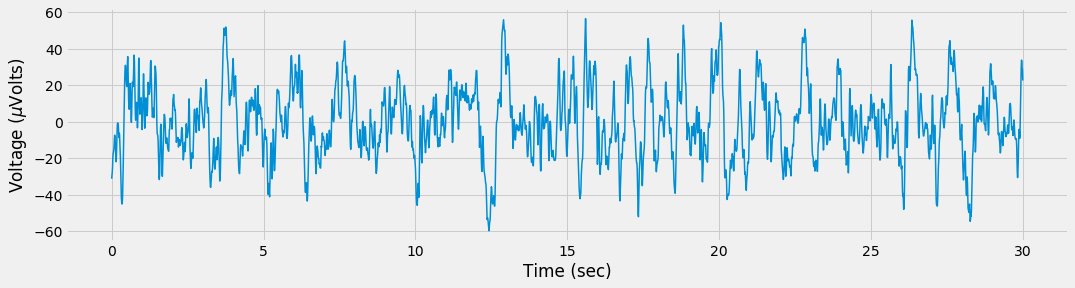

In [9]:
eeg = np.loadtxt('data/EEG.txt')
sr = 100 # samples per second
Nysquid = sr/2
print('Nysquid frequency is %d Hz'%Nysquid)
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(np.arange(eeg.size)/sr, eeg, lw = 1.5)
plt.xlabel('Time (sec)'), plt.ylabel('Voltage ($\mu$Volts)');

In [10]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, sr/2., num = Nsamples + 1 )
print('Spectral resolution = %2.4f Hz'%hz[1])

Spectral resolution = 0.0333 Hz


In [11]:
# Perform Welch's periodogram with hann window and 50% overlap
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)


# obtain simply Power (uV^2) with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, 
                noverlap = segment/2, scaling = 'spectrum', return_onesided=True)

freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

# obtain Power density (uV^2/Hz) with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, 
                 noverlap = segment/2, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


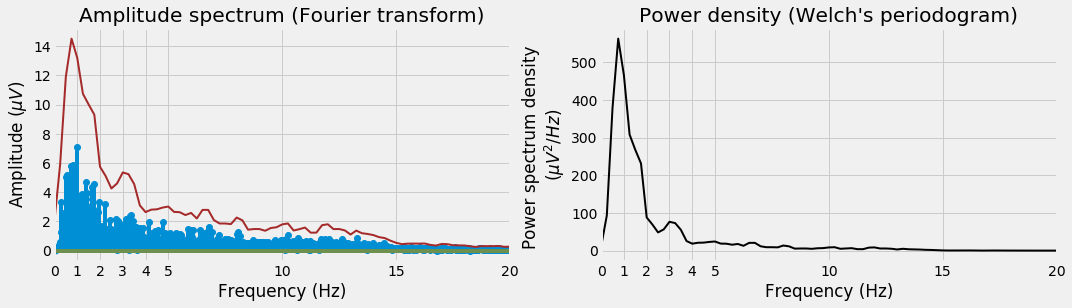

In [12]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps), color='brown', lw = 2)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power density (Welch's periodogram)")
ax[1].plot(freq, psd, color='k', lw=2)

ax[1].set_ylabel('Power spectrum density \n($\mu V^2/Hz$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,20)
    myticks = list(range(6)) + list(range(10, 25,5))
    myax.set_xticks(myticks)

In [13]:
# compute the signal at 1 Hz
print('Signal amplitude @1Hz     = %2.4f uVolts'%amp[int(1/dhz)]) 
print('Signal power @1Hz         = %2.4f uVolts^2'%ps[int(1/dfreq)])
print('Singal power density @1Hz = %2.4f uVolts^2/Hz'%psd[int(1/dfreq)])

Signal amplitude @1Hz     = 7.1204 uVolts
Signal power @1Hz         = 174.5056 uVolts^2
Singal power density @1Hz = 465.3483 uVolts^2/Hz


The relative band (absolute power divided by the total power of the spectrum)
can be calculated, irrespective of if power of power densities are given in 
the Welch's spectrum.

In [14]:
# compute delta-band
idx_delta = np.logical_and(freq >= 0.4, freq <=4)
delta_power = simps(psd[idx_delta], dx = dfreq)
total_power = simps(psd, dx = dfreq)

print('Absolute delta power: %.3f uV^2' % delta_power)
print('Relative delta power: %.3f ' % (delta_power/total_power))

Absolute delta power: 642.128 uV^2
Relative delta power: 0.787 


Plotting in logaritmic scale for the delta-band is not really useful

((0, 40), (0.1, 1000))

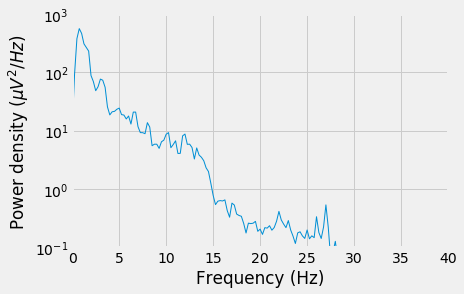

In [15]:
# plot in logaritmic scale
plt.semilogy(freq, psd, lw = 1)
plt.xlabel('Frequency (Hz)'), plt.ylabel('Power density ($\mu V^2/Hz)$')
plt.xlim(0,40), plt.ylim(0.1,1000)